## Алгоритм оптимизации суперпозиции моделей

In [234]:
import io
import requests
import seaborn as sns
import pickle
import os
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [232]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import itertools


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import copy
import math

import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.float_format','{:,.5f}'.format)
pd.set_option('display.max_columns', None)
from IPython import display

In [4]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = [7, 5]
### Сохранение изображения ###
plt.savefig('1.svg') # Поддерживаемые форматы: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

<Figure size 504x360 with 0 Axes>

In [5]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

In [6]:
from utils import *

## Логистическая регрессия. Алгоритм Ньютона-Рафсона. В оптимизации участвует ковариационная матрица признаков.

In [7]:
def preprocess(arr):
    # Adds fictitious feature equal to 1
    
    ones = np.array([[1]*arr.shape[0]]).T
    arr_b = np.concatenate((ones, arr), axis=1)
    return arr_b

In [8]:
def sigmoid(z):
    # Activation function used to map any real value between 0 and 1
    
    sig = 1 / (1 + np.exp(-z))     # Define sigmoid function
    sig = np.minimum(sig, 0.99999999999999999999999999)  # Set upper bound
    sig = np.maximum(sig, 0.00000000000000000000000001)  # Set lower bound
    return sig 

In [9]:
def cross_entropy(T, Y):
    # Computes the cost function for all the training samples
    
    E = 0
    for i in range(T.shape[0]):
        if T[i] == 1:
            E -= np.log(Y[i])
        else:
            E -= np.log(1 - Y[i])
    return E/T.shape[0]

In [88]:
import random

In [184]:
def step_of_NR_algo(Y, w, Xb, T_):
    # Computes one step of Newton-Raphson method
    
#     SGD
#     k = 128
#     indx = random.sample(range(len(Xb)), k)
#     Y = Y[indx]
#     Xb = Xb[indx]
#     T_ = T_[indx]
    
    b = Y*(1-Y)
    B = np.diag(b)

    inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
    cov_w_matrix = np.linalg.pinv(inverse_of_A)
    var_w = cov_w_matrix.diagonal()

    Xt = np.transpose(Xb)
    XtB = Xt.dot(B)
    XtBX = XtB.dot(Xb)
#     print(i)
#     print(w)
#     print(Y)
    #inverse_of_H = np.linalg.pinv(XtBX + var_w*1e-19)
    inverse_of_H = np.linalg.pinv(XtBX + var_w)
#     pdb.set_trace()

#     Y = Y.reshape(-1,1)
#     T_ = T_.reshape(-1,1)
    derivative_of_logloss = np.dot(Xb.T, (Y-T_))

    w = w - inverse_of_H.dot(derivative_of_logloss + var_w*w)
    
    return w, var_w, b

In [185]:
def filter_columns(Xb_test, cols):
    # Returns array filtered by given columns
    
    Xb_test = pd.DataFrame(data=Xb_test, columns = [str(i) for i in range(Xb_test.shape[1])])
    filtered_Xb_test = np.array(Xb_test[cols])
    return filtered_Xb_test

In [186]:
def predict_estimates(X_test, w, feat_obj_selection=False, cols=None):
    # Returns probabilities
    
    Xb_test = preprocess(X_test)
    if feat_obj_selection:
        Xb_test = filter_columns(Xb_test=Xb_test, cols=cols)
    z_test = Xb_test.dot(w)
    probability_estimates = sigmoid(z_test)
    return probability_estimates

In [187]:
class LogisticRegressionModel(object):
    """A logistic regression model for fitting and predicting binary response data.
    
    Attributes:
        X: the predictor matrix,
        T: the response vector 
    """    

    def __init__(self):
        self.w = None
        
    def set_weights(self, w):
        self.w = w
    
    def fit(self, X, T, iterations=12):

        X_ = copy.deepcopy(X)
        T_ = copy.deepcopy(T)

        N, D = X_.shape

        Xb = preprocess(X_)
        
        if self.w is None:
            self.w = np.ones(D+1)*math.log(T_.mean()/(1-T_.mean()))
#         w = np.ones(D+1)*math.log(T_.mean()/(1-T_.mean()))
        
        list_w = []
        list_var_w = []
        list_var_obj = []
        costs = []
        self.converged = False

        for i in range(iterations):

            Y_hat = sigmoid(Xb.dot(self.w))
            Y = Y_hat
            Y[Y==1.0] = 0.999999
            Y[Y==0.0] = 0.000001

            costs += [cross_entropy(T_, Y)]
            
            if i>1:
                if not self.converged and abs(costs[-1]-costs[-2])<.000001:
                    self.converged = True
                    self.converged_k = i+1

            self.w, var_w, b = step_of_NR_algo(Y, self.w, Xb, T_)

           # w = w - learning_rate *(np.dot(Xb.T, (Y-T)) + var_w*w*1e-19)

           # inverse_of_A = np.dot(w.reshape(D+1,1), w.reshape(1,D+1))/D
           # var_w = np.linalg.pinv(inverse_of_A).diagonal()
            list_w.append(self.w)
            list_var_w.append(var_w)
            list_var_obj.append(Y*(1-Y))

        self.list_w = list_w
        self.list_var_w = list_var_w 
        self.list_var_obj = list_var_obj
        self.costs = costs
        
        if not self.converged:
            print('Недостаточно итераций для сходимости алгоритма.')
        else:
            print('\nАлгоритм сошелся за {} итераций'.format(self.converged_k))

        return self
 
    def predict(self, X):
        return predict_estimates(X, self.w, feat_obj_selection=False, cols=None)
    
    def cross_entropy(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    #Вспомогательные методы
    def plot_weights(self):
        plt.scatter(np.arange(len(self.w)), self.w, label='w map')
        plt.legend()
    
    def plot_cross_entropy(self):
        plt.plot(np.arange(len(self.costs)),self.costs)
        plt.xlabel('Iteration number')
        plt.ylabel('Cross-Entropy')
        plt.title('Зависимость S от номера итерации')   
        
    def make_report(self):
        """
        Prints a formatted table of the model coefficients 
        """
        
        if not self.converged:
            print('\nНедостаточно итераций для сходимости алгоритма.')
        else:
            print('\nАлгоритм сошелся за {} итераций'.format(self.converged_k))

## Реализация Н-Р с отбором признаков по дисперсиям и метрическим блоком

In [188]:
def select_objects(Y, obj_threshold, Xb, T):
    # Returns objects with low variance
    
    b_temp = Y*(1-Y)
    mask = b_temp<obj_threshold
    Xb = Xb[mask]
    Y = Y[mask]
    T = T[mask]
    
    return Xb, Y, T

In [189]:
def select_features(w, Xb, feat_threshold, cols):
    # Returns features with low variance
    
    inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
#     cov_w_matrix = np.linalg.pinv(inverse_of_A)
    try:
        cov_w_matrix = np.linalg.inv(inverse_of_A)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            cov_w_matrix = np.linalg.pinv(inverse_of_A)
    var_w = cov_w_matrix.diagonal()

    print('Дисперсии весов')
    print(var_w)
    print('\nСписок выбранных на текущей итерации признаков')
    print(cols)
    print('\nРазмер матрицы Плана на текущей итерации')
    print(Xb.shape)
    mask2 = np.abs(var_w)<feat_threshold
    cols = [col for col, mask in zip(cols, mask2) if mask]
    w = w[mask2]
    Xb = Xb[:, mask2]
    
    return cols, w, Xb

In [190]:
def my_kmeans(n_clusters, X):
    
    # В scipy есть замечательная функция, которая считает расстояния
    # между парами точек из двух массивов, подающихся ей на вход
    from scipy.spatial.distance import cdist

    # Прибьём рандомность и насыпем случайные центроиды для начала
    np.random.seed(seed=42)
    centroids = X[10:10+n_clusters]
#     centroids = np.random.normal(loc=0.0, scale=1., size=5*X.shape[1])
#     centroids = centroids.reshape((5, X.shape[1]))

    cent_history = []
    cent_history.append(centroids)

    for i in range(10):
        # Считаем расстояния от наблюдений до центроид
        distances = cdist(X, centroids)
        # Смотрим, до какой центроиде каждой точке ближе всего
        labels = distances.argmin(axis=1)

        centroids = centroids.copy()
        for i in range(n_clusters):
            # Положим в каждую новую центроиду геометрический центр её точек
            centroids[i, :] = np.mean(X[labels == i, :], axis=0)

        cent_history.append(centroids)
        
        return cent_history[-1]

In [191]:
def predict_estimates_with_MF(X_test, w, cols, cluster_centers, metric_mask):
    if len(cluster_centers) == 0:
        probab_estimates = predict_estimates(X_test, w, feat_obj_selection=True, cols=cols)
    else:
        Xb_test = preprocess(X_test)
        not_metric_features = [x for x in cols if 'cluster_' not in x]
        Xb_test = filter_columns(Xb_test=Xb_test, cols=not_metric_features)
        metric_features_for_test = pairwise_distances(Xb_test, cluster_centers)[:, metric_mask]
        Xb_test_new = np.hstack((Xb_test, metric_features_for_test))
        z_test = Xb_test_new.dot(w)
        probab_estimates = sigmoid(z_test)
    return probab_estimates

In [192]:
def metric_block(Xb, cols, n_clusters, i, algo_clust='km_sklearn'):
    not_metric_features = ['cluster_' not in x for x in cols]
    
    if algo_clust=='km_simple':
        new_centroids = my_kmeans(n_clusters, Xb[:, not_metric_features])
    
    elif algo_clust=='km_sklearn':
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

        bc = np.bincount(kmeans.labels_)
        new_order = sorted(range(n_clusters), key=lambda x: bc[x])
        new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])
    
    elif algo_clust=='gmm':
        not_metric_features = ['cluster_' not in x for x in cols]
        data = Xb[:, not_metric_features]
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(data)
        prediction_gmm = gmm.predict(data)
        probs = gmm.predict_proba(data)

        centers = np.zeros((n_clusters, data.shape[1]))
        for i in range(n_clusters):
            density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(data)
            centers[i, :] = data[np.argmax(density)]
        new_centroids=centers
    
    metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
    scaler = StandardScaler()
    metric_features = scaler.fit_transform(metric_features)

    print('\nМассив метрических признаков на {}-й итерации'.format(i))
    print(metric_features)

    cluster_centers = new_centroids

    new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

    # Кластера из предыдущей итерации
    metric_cols = [x for x in cols if 'cluster_' in x]

    # metric_cols = new_metric_cols[metric_mask]
    metric_mask = [x in metric_cols for x in new_metric_cols]

    # Маска длины cols для кластеров, True только там, где кластера.
    # Позволяет выделить измененные на предыдущей итерации метрические признаки
    metric_all_mask = ['cluster_' in x for x in cols]
    Xb[:, metric_all_mask] = metric_features[:, metric_mask]
    
    return metric_mask, cluster_centers

In [193]:
class SuperpositionModel(LogisticRegressionModel):
    """A logistic regression model for fitting and predicting binary response data.
    
    Attributes:
        X: the predictor matrix,
        T: the response vector 
    """    
    
    def __init__(self):
        # Необходимо вызвать метод инициализации родителя.
        # В Python 3.x это делается при помощи функции super()
        super().__init__()
        
    def fit(self, X, T, feat_threshold, n_clusters, iterations=10, obj_threshold=100, algo_clust='km_sklearn'):

        X_ = copy.deepcopy(X)
        T_ = copy.deepcopy(T)

        N, D = X_.shape

        Xb = preprocess(X_)
        Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))

        cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]

        if self.w is None:
#             self.w = np.random.randn(D + 1 + n_clusters)*0.02
#             self.w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.02
            self.w = np.ones(D+1 + n_clusters)*-0.07710948
#             self.w = np.random.uniform(-0.1, 0.1, D + 1 + n_clusters)

        list_w = []
        list_var_w = []
        list_var_obj = []
        costs = []
        cluster_centers = []
        metric_mask = []
        self.converged = False

        for i in range(iterations):
            print('\n{}-я итерация'.format(i))
            print('\nВеса')
            print(self.w)

            if n_clusters == 0:
                cluster_centers = []
                metric_mask = []

            if i!=0:
                cols, self.w, Xb = select_features(self.w, Xb, feat_threshold, cols)
                if n_clusters != 0:
                    metric_mask, cluster_centers = metric_block(Xb, cols, n_clusters, i, algo_clust)

            # Модель
            Y = sigmoid(Xb.dot(self.w))

            print('\nСкоры объектов на {}-й итерации'.format(i))
            print(Y)

            Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)

            costs += [cross_entropy(T_, Y)]
            
            if i>1:
                if not self.converged and abs(costs[-1]-costs[-2])<.000001:
                    self.converged = True
                    self.converged_k = i+1

            self.w, var_w, b = step_of_NR_algo(Y, self.w, Xb, T_)
            
            list_w.append(self.w)
            list_var_w.append(var_w)
            list_var_obj.append(Y*(1-Y))

            self.list_w = list_w
            self.list_var_w = list_var_w 
            self.list_var_obj = list_var_obj
            self.costs = costs
            self.cols = cols
            self.metric_mask = metric_mask
            self.cluster_centers = cluster_centers

            if not self.converged:
                print('Недостаточно итераций для сходимости алгоритма.')
            else:
                print('\nАлгоритм сошелся за {} итераций'.format(self.converged_k))

        return self
    
    def get_costs(self):
        return self.costs
    
    def get_cols(self):
        return self.cols
    
    def get_weights(self):
        return self.w
    
    def predict(self, X):
        return predict_estimates_with_MF(X, self.w, self.cols, self.cluster_centers, self.metric_mask)  

In [194]:
def plot_feature_importance(w, cols):
    feature_importance = abs(w)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(cols)[sorted_idx])
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()

## Тестирование

In [219]:
from sklearn.datasets import make_classification
ds = make_classification(n_samples=7550, n_features=24, n_informative=12, 
                         flip_y=0.01, random_state=42)

In [220]:
X, T = ds

In [221]:
X, X_test, T, t_test = train_test_split(X, T, test_size=0.33, random_state=42)

In [222]:
clf = SuperpositionModel()

In [223]:
# w
# [-0.2511382   0.07492982  0.24136076 -0.07290292 -0.11967191  0.02365076
#   0.02839169 -0.00287426 -0.0088931  -0.26341929  0.03093513  0.0078953
#  -0.05253529 -0.05207926 -0.27679191  0.23475076 -0.01623667  0.01856821
#  -0.00180189  0.17435904  0.04515082  0.04406373 -0.00094066  0.03971778
#   0.01814321 -0.13897026 -0.07486479 -0.07048733  0.00945523  0.01343596
#  -0.01371954 -0.00812048  0.02381789  0.03582728 -0.08092453]
# хорошие веса на 10 кластеров, порог дисперсий = 1e+21, km_simple

In [224]:
# w = np.array([ 0.09171938, -0.0113631,  -0.01765564 ,-0.00116078, -0.01534879,  0.0398073 ,
#          -0.08100533 ,-0.05287392 ,-0.05357995 , 0.04732558 , 0.08534087, -0.00541226,
#          -0.00863089 , 0.00331281  ,0.05790412, -0.04655746 , 0.01172865 , 0.04857008,
#           0.02486491 , 0.00928928 , 0.0498625 , -0.13535141 , 0.03370397, -0.03289358,
#          -0.09172144 , 0.02537033,  0.06849313, -0.00706223,  0.04745393 , 0.08042411])
# clf.set_weights(w)

In [225]:
%%time
clf.fit(X, T, feat_threshold=1e+21, n_clusters=5, iterations=15, algo_clust='km_sklearn')


0-я итерация

Веса
[-0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948]

Скоры объектов на 0-й итерации
[0.39703603 0.34760757 0.56806226 ... 0.56112091 0.53794051 0.53021378]
Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.26405549  0.00080066  0.33750019 -0.15669885 -0.33021774 -0.00362186
  0.04200193  0.01822104 -0.00374355 -0.34246139  0.05112575  0.01323846
 -0.03430441  0.03061247 -0.19092967  0.19551846  0.0027448   0.03045759
  0.12893758  0.25789227  0.06355992  0.03570185 -0.20554261  0.0130993
  0.0225002  -0.38970236 -0.38970236 -0.38970236 -0.38970236 -0.38970236]
Дисперсии весов
[1.05533086e+00 9.70268602e-06 1.72403579e+00 3.71646352e-01



Массив метрических признаков на 5-й итерации
[[ 0.62019304 -1.07515958  1.91162428  1.4263389   1.14293097]
 [ 0.73273311 -0.263735    0.86216005  0.57604274 -0.32830367]
 [-0.64453433 -1.46801078 -0.40833569 -1.72074909 -0.53214409]
 ...
 [ 1.48217419  1.65610494 -0.72591347  0.01010945  0.30818704]
 [ 0.39714635  0.73972155 -0.60560382 -1.2741827   0.4643027 ]
 [ 0.02178212 -0.59115227 -0.19937638 -0.87066463 -1.64388256]]

Скоры объектов на 5-й итерации
[0.04264284 0.79081987 0.11990186 ... 0.56507948 0.73317235 0.91454484]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.67738401 -0.2917094   0.05098041  0.21719688 -0.37395509  0.40073282
  0.03418617 -0.77371112  0.07283649 -0.0966543   0.23137817  0.05800553
  0.80233294  0.00895085 -0.41440935 -0.00668725  0.07804841 -0.30198513
 -0.04281789  0.41563077 -0.02559361 -0.4690329   2.96403338  1.55866428
 -1.08594603 -2.24733256]
Дисперсии весов
[-2.36997597e+17  4.22744880e+18  6.69134657e+19 -1.94395020e+18


Массив метрических признаков на 11-й итерации
[[ 0.72737143 -1.14611475  1.90913797  1.42093525  1.22793182]
 [ 0.75614664 -0.19062348  0.94657875  0.69588867 -0.29170759]
 [-0.75658428 -1.4131392  -0.33058116 -1.63991182 -0.52039766]
 ...
 [ 1.3467775   1.66117416 -0.7407362   0.06016153  0.13986867]
 [ 0.57675828  0.79921932 -0.53569334 -1.28635341  0.55284073]
 [ 0.00558154 -0.51745345 -0.11535512 -0.75416527 -1.68342892]]

Скоры объектов на 11-й итерации
[0.04090443 0.79284908 0.11987624 ... 0.56397355 0.73825999 0.91458774]

Алгоритм сошелся за 12 итераций

12-я итерация

Веса
[-0.73408494 -0.24228489  0.36953067 -0.140391    0.49685309  0.03474917
 -0.73986771  0.07143974 -0.0984066   0.1682597   0.01308145  0.93342514
 -0.59800251 -0.08711589  0.07505394 -0.28670028  0.21539086  0.52498372
 -0.02736592 -0.49127432  2.97493038  1.46836396 -1.05744455 -2.10285087]
Дисперсии весов
[ 9.52732419e+16  8.17285657e+14 -3.50685377e+17 -4.09450821e+18
  4.79098949e+17  1.82306112e+20 -3.

In [226]:
roc_auc_score(t_test, clf.predict(X_test))

0.8315683789076724

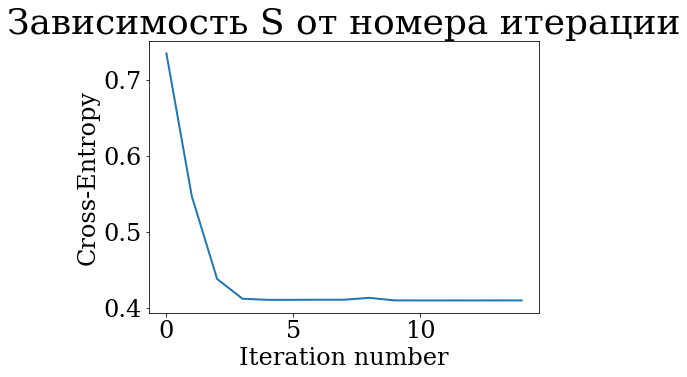

In [227]:
clf.plot_cross_entropy()

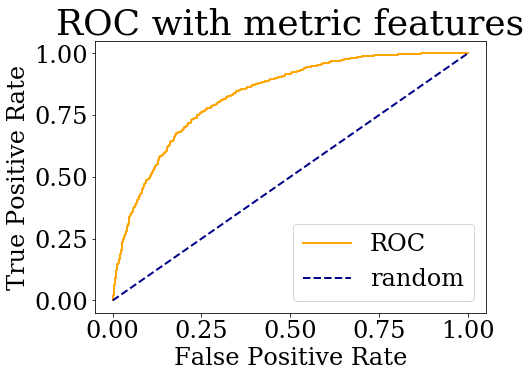

In [228]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, clf.predict(X_test), pos_label=None)
plot_roc_cur(fpr, tpr, title='ROC with metric features')

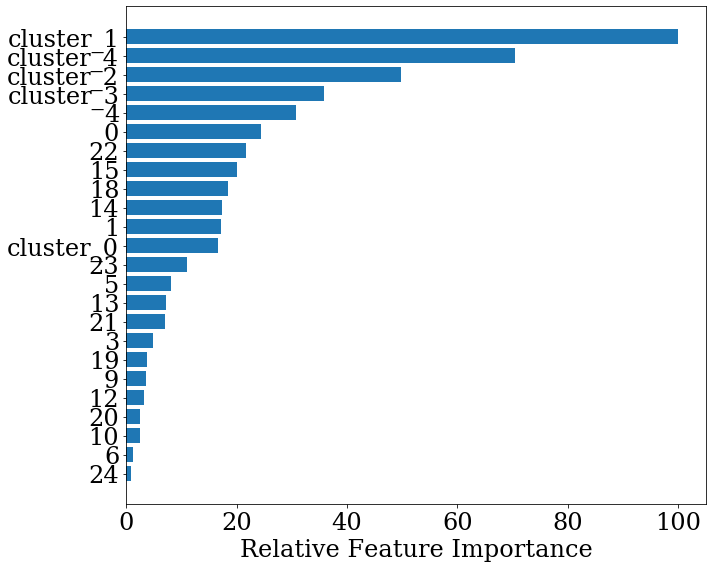

In [229]:
w = clf.get_weights()
cols = clf.get_cols()
plot_feature_importance(w, cols)

In [212]:
T = np.array(T)

costs = []
rocs = []
rocs_val = []
preds_test = []
list_w3_ = []
list_var_w3_ = []

n_bootstraps = 10
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

i = 0
X_train_, X_val_, T_train_, T_val_ = train_test_split(X, T, test_size=0.33, random_state=42)
for i in range(n_bootstraps):
    
    print('**************')
    print('\n{}-я итерация бутстрэпа'.format(i))
        
    train_index = list(rng.random_integers(0, len(X_train_) - 1, len(X_train_)))
    test_index = list(rng.random_integers(0, len(X_val_) - 1, len(X_val_)))

#     print('ИТЕРАЦИЯ', i)
    X_train, X_val = X_train_[train_index], X_val_[test_index]
    t_train, t_val = T_train_[train_index], T_val_[test_index]
    clf = SuperpositionModel()
    clf.fit(X=X_train, T=t_train, feat_threshold=1.0*1e+20, n_clusters=10, algo_clust='gmm')
    costs.append(copy.deepcopy(clf.get_costs()))
    
    pred3 = clf.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(t_train, pred3, pos_label=None)
    rocs.append((fpr, tpr))
    
    pred3_val = clf.predict(X_val)
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(t_val, pred3_val, pos_label=None)
    rocs_val.append((fpr_val, tpr_val))
    
    pred3_test = clf.predict(X_test)
    preds_test.append(pred3_test)
    
    i = i+1
    

**************

0-я итерация бутстрэпа

0-я итерация

Веса
[-0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948]

Скоры объектов на 0-й итерации
[0.5228804  0.92070254 0.47350257 ... 0.20469554 0.33251668 0.32148249]
Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[ 5.14597656e+11  5.42951959e+11 -4.50719963e+11 -2.95936936e+11
  2.22459165e+11  5.64966721e+11 -1.47131882e+10 -3.32964102e+11
  2.12882765e+11 -8.09645935e+11  2.50911683e+09  2.85328108e+11
 -1.07889665e+11 -5.22399716e+11 -6.63602663e+11  7.29199244e+11
  3.37045231e+11  2.32983822e+11 -1.57102335e+11 -3.21304169e+10
  4.67742701e+10 


Массив метрических признаков на 9-й итерации
[[-0.24213833 -0.36012377  0.10105167 ...  0.86899545 -0.86190641
   1.07750325]
 [ 0.75172985 -0.23043926  0.5923705  ...  0.87845953  0.98017501
   0.14009475]
 [ 0.21826054  0.90260188  0.31453664 ... -1.63557616  1.34649964
  -1.4096717 ]
 ...
 [ 0.60504766  0.48515592  0.97124167 ...  1.02741506 -1.60198259
   1.54064121]
 [ 0.39964337  0.43482596 -0.49330043 ... -0.63922929  0.11449814
  -0.51608107]
 [-0.78238411 -1.06886981 -1.29402345 ... -0.28565008 -0.20440529
  -0.5474814 ]]

Скоры объектов на 4-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-5.11047930e+26 -3.88617340e+25  2.57991902e+25  5.32256324e+25
  3.71672004e+25 -7.18229629e+25  3.67888622e+24  4.38413227e+25
 -2.05375099e+25  9.14803312e+25 -4.19006739e+24 -5.23788748e+25
  1.44799217e+25 -4.54654652e+24  7.43548525e+25 -1.71863635e+25
 -3.57573818e+25 -3.60682914e+25 -1.52902673e+25  1.43


Массив метрических признаков на 9-й итерации
[[ 0.2819584   0.83643556  0.58815221 ... -0.36012377  0.10105167
  -0.36012377]
 [ 0.58087832 -1.47985348  0.49485391 ... -0.23043926  0.5923705
  -0.23043926]
 [ 1.22171758 -0.28348595 -2.08334673 ...  0.90260188  0.31453664
   0.90260188]
 ...
 [ 0.76020937  1.43952908  1.15396283 ...  0.48515592  0.97124167
   0.48515592]
 [-0.68397844  0.03431497 -0.17422764 ...  0.43482596 -0.49330043
   0.43482596]
 [-0.55611744 -0.17313096 -0.46466184 ... -1.06886981 -1.29402345
  -1.06886981]]

Скоры объектов на 8-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-4.50586649e+26 -3.14602941e+25  2.17514138e+25  3.25169665e+25
  4.90310797e+25 -4.20263165e+25 -2.99006588e+24  3.56977470e+25
 -1.35320361e+25  7.41761580e+25  6.89500013e+24 -3.77867812e+25
  4.87160289e+24 -3.69732060e+25  6.87005167e+25  8.68895537e+24
 -1.87178952e+25 -2.27736161e+25 -8.99647005e+24  8.152


Массив метрических признаков на 9-й итерации
[[-0.51138469 -0.33289824  0.35144945 ... -0.71547265 -0.34028965
   0.18222204]
 [-1.73021544 -0.03047151 -0.25709037 ... -1.69789908 -0.67218334
  -0.38964498]
 [ 0.34139338 -0.417271    0.46770793 ...  1.78683295  0.21180714
   0.99371107]
 ...
 [-0.45999821 -0.14250991  0.36958854 ...  0.91131571 -1.59623834
   1.45611927]
 [-0.2207307  -0.35472698  0.96729334 ...  1.32810996  1.52373005
   0.65576171]
 [-1.42723192 -0.34894663 -0.53616508 ... -0.58160937 -0.41556962
  -0.7504697 ]]

Скоры объектов на 3-й итерации
[1.e-26 1.e+00 1.e+00 ... 1.e+00 1.e+00 1.e-26]
Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-7.12799456e+25 -6.78289161e+24 -1.52600133e+25  4.00312708e+25
 -1.33602611e+25 -5.14764708e+25 -1.05846437e+25 -1.94955823e+25
 -1.98289251e+24  3.58928953e+25  2.63761135e+23  6.77604355e+24
  4.32527527e+24 -1.56591416e+25  3.27054605e+25  2.02725128e+25
 -4.08009177e+25  1.16645256e+25 -3.23908132e+25  3.11


Массив метрических признаков на 9-й итерации
[[ 0.35144945 -0.16171686 -0.8544586  ... -0.42554634  0.44599635
  -0.80012524]
 [-0.25709037 -0.08002677 -0.47110654 ... -0.83495589 -0.1805566
  -1.62354871]
 [ 0.46770793  1.13079189 -1.71733257 ...  1.61723703  0.95238184
   1.66958599]
 ...
 [ 0.36958854  0.21313942 -1.07368396 ...  1.27533953  1.01508444
   0.46035749]
 [ 0.96729334  1.36902136  0.0534139  ...  1.43193678  1.43983909
   1.00158605]
 [-0.53616508 -1.37167988 -1.28381186 ... -0.83839019 -0.02372021
  -1.24473097]]

Скоры объектов на 7-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-7.22230013e+26 -6.64546341e+25 -5.55746808e+25 -7.98332284e+24
  2.41727344e+25  4.74248950e+25 -8.03375233e+25 -9.04337521e+25
 -2.82691217e+25  1.25866963e+26 -7.15241467e+25  7.72565509e+24
  1.83178554e+25  1.08864989e+26 -3.50833139e+25  5.31726998e+25
  1.94967669e+25  5.00775123e+25 -1.05961272e+26  8.239


Массив метрических признаков на 9-й итерации
[[-0.79947865  0.10951401  0.22734419 ...  0.33324641 -0.35476354
   0.33324641]
 [ 0.20855017  0.21437289  0.25329347 ... -0.15129779 -0.08586194
  -0.15129779]
 [-0.73996077 -0.52608054 -1.78073947 ... -0.54925687 -0.11773856
  -0.54925687]
 ...
 [ 1.28834768  0.31037551  0.70515067 ...  0.49447131  0.40648033
   0.49447131]
 [ 0.23544947  0.24747594  0.57454962 ...  0.04344854 -0.53123778
   0.04344854]
 [-0.52228894 -2.11952764 -0.17733252 ... -0.42677492 -0.70469471
  -0.42677492]]

Скоры объектов на 2-й итерации
[1.e+00 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e+00]
Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-4.04216634e+26 -1.41900522e+26 -1.76306081e+26  1.98228821e+26
  9.05427814e+24  4.72113590e+25 -1.18910480e+25  7.70468160e+25
  1.74472928e+25 -2.48107071e+25 -2.53601214e+25  3.49469764e+25
 -2.12594571e+25  1.58840075e+26  1.17591133e+26  1.74995949e+26
 -3.57465339e+25 -3.21455918e+25 -8.34805286e+25  5.90


Массив метрических признаков на 9-й итерации
[[-1.14205927  0.22734419  0.37143822 ... -1.95342625  0.66795988
   0.10951401]
 [ 0.30961743  0.25329347 -1.24134926 ... -0.26018066  0.65748394
   0.21437289]
 [ 0.44668617 -1.78073947 -0.02275567 ...  0.17721291 -0.43306697
  -0.52608054]
 ...
 [ 1.62733425  0.70515067 -0.04517766 ...  1.47179671  0.86853036
   0.31037551]
 [ 0.65129108  0.57454962 -1.10886161 ...  0.11543411  1.29216017
   0.24747594]
 [-0.8645995  -0.17733252 -0.24149645 ... -0.69933613 -0.08318765
  -2.11952764]]

Скоры объектов на 6-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-4.32845273e+26 -1.14958807e+26 -1.23951601e+26  2.04830572e+26
 -3.54299325e+25  6.37631493e+25 -2.97278854e+25  6.49659583e+25
  2.45726253e+25  2.49342348e+25 -2.94885096e+25 -6.33657991e+24
 -2.01548527e+25  1.83894274e+26  6.63540959e+25  2.14591498e+26
 -1.38134328e+25 -3.50393406e+25 -1.24219655e+26  4.62


Массив метрических признаков на 9-й итерации
[[-4.18648973e-04 -1.91408553e+00 -2.95420047e-01 ...  1.75869431e-01
   1.75869431e-01  1.42726875e-01]
 [ 2.18150392e-01 -6.99776699e-01 -4.60545361e-01 ...  3.00055753e-02
   3.00055753e-02  4.50701405e-01]
 [-6.65834543e-01 -6.36877937e-01 -9.89852307e-01 ... -1.95044143e+00
  -1.95044143e+00 -1.34956784e-01]
 ...
 [-1.05761663e+00  6.63904525e-01 -3.32564162e-01 ... -9.61484028e-01
  -9.61484028e-01 -2.32232993e-01]
 [ 1.14733497e+00 -9.36126656e-01 -2.68167280e-01 ... -2.32362982e-01
  -2.32362982e-01  5.41386874e-01]
 [-8.29579931e-01  2.19326270e-01 -4.89332937e-01 ... -1.28236255e+00
  -1.28236255e+00 -6.99215233e-01]]

Скоры объектов на 1-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e+00 1.e+00 1.e+00]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-2.74965110e+26 -2.20511331e+26 -9.89121103e+25  2.40403541e+26
 -1.72501719e+26 -7.93222210e+25  7.06753790e+24  1.09379679e+26
 -2.04557848e+25  3.37181323e+25  8.5637


Массив метрических признаков на 9-й итерации
[[ 0.33077908 -1.17313165  0.165253   ... -0.29542005  0.08632583
   0.17586943]
 [-0.12702145 -0.10923391  0.22349664 ... -0.46054536  0.05884626
   0.03000558]
 [-0.79492065 -1.50520039 -1.77717941 ... -0.98985231 -1.6495318
  -1.95044143]
 ...
 [ 0.12707877 -0.25489605 -0.42649921 ... -0.33256416 -0.97381895
  -0.96148403]
 [-2.08410911 -0.38521577 -0.71150417 ... -0.26816728 -0.86740704
  -0.23236298]
 [-0.70368344 -0.47586084 -1.13042246 ... -0.48933294 -1.54950433
  -1.28236255]]

Скоры объектов на 5-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-3.80475530e+26 -1.97087693e+26 -1.34566450e+26  1.79772621e+26
 -1.49256381e+26 -5.43964030e+25  2.50633682e+25  8.66617874e+25
 -1.99771355e+25 -1.10259002e+24 -6.46090542e+23 -4.16148091e+25
 -1.12418731e+25  1.16953005e+26  2.01055822e+26  7.41798943e+25
 -1.95771043e+24  3.96614882e+25  4.02934435e+25  3.644


Массив метрических признаков на 9-й итерации
[[-1.42784883  1.15169373 -0.13689759 ...  0.43939185  0.17586943
  -0.29542005]
 [-0.55272757 -0.29395657  0.93074426 ...  0.47908569  0.03000558
  -0.46054536]
 [-1.13978419 -1.65887889 -0.70325401 ... -0.66738949 -1.95044143
  -0.98985231]
 ...
 [ 0.25315868 -0.89072713 -0.3720976  ... -0.72944308 -0.96148403
  -0.33256416]
 [-0.0930292  -1.13007049 -0.10221929 ...  0.31863344 -0.23236298
  -0.26816728]
 [-0.30548413 -2.19839382 -0.76724298 ... -1.21234588 -1.28236255
  -0.48933294]]

Скоры объектов на 9-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.
**************

4-я итерация бутстрэпа

0-я итерация

Веса
[-0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.0771


Массив метрических признаков на 9-й итерации
[[-0.79969615 -0.88737782 -2.41472326 ... -0.48547892 -0.53381184
  -1.82036082]
 [-0.0937014  -0.67621209  0.05036992 ... -0.24735409 -0.21250285
  -0.01086694]
 [ 0.7387898   0.04795763 -0.07562794 ... -0.71983795 -0.32857638
   0.28063722]
 ...
 [-0.0617383  -0.13066589 -0.48170909 ... -1.70066035 -1.74210214
  -0.59957417]
 [-0.1410887   0.60616579 -0.26534781 ... -1.23157589 -0.61168323
  -0.08428996]
 [ 1.52937529  1.01507131 -1.22121414 ...  1.4166703   1.36419198
   0.3393237 ]]

Скоры объектов на 4-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e+00 1.e+00 1.e-26]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-4.27548424e+26 -2.18855981e+25 -1.47083067e+26  1.19104568e+26
  5.56656621e+24 -2.60791003e+25  2.16385250e+25  9.73461866e+25
  2.21498891e+24  4.48734591e+24  7.32933652e+24 -8.51486082e+24
 -3.04206503e+24  4.70153840e+25  2.15934418e+26  1.45980551e+26
 -1.63149379e+25  2.51334132e+25  2.21575480e+25  5.98


Массив метрических признаков на 9-й итерации
[[-0.88737782 -1.50203958 -1.77394117 ... -0.79969615 -2.41472326
  -0.48547892]
 [-0.67621209  0.11776765  0.88473351 ... -0.0937014   0.05036992
  -0.24735409]
 [ 0.04795763  0.3701938   0.90097766 ...  0.7387898  -0.07562794
  -0.71983795]
 ...
 [-0.13066589 -0.45315609 -0.17589443 ... -0.0617383  -0.48170909
  -1.70066035]
 [ 0.60616579  0.41686941  0.04746958 ... -0.1410887  -0.26534781
  -1.23157589]
 [ 1.01507131  0.53151503 -0.89368243 ...  1.52937529 -1.22121414
   1.4166703 ]]

Скоры объектов на 8-й итерации
[1.e-26 1.e+00 1.e+00 ... 1.e+00 1.e+00 1.e-26]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-7.49668955e+26  1.41293775e+26 -2.66297483e+26  1.07288836e+26
 -6.78629522e+25 -1.24686039e+26  7.99623274e+25  8.89788266e+25
 -2.63003797e+25  9.31708832e+25  2.48814415e+25 -3.16054467e+22
 -1.50687041e+25 -3.75662248e+25  4.72219311e+26  2.04462330e+26
 -8.90419740e+24  4.36415768e+25  1.69398376e+25 -8.84


Массив метрических признаков на 9-й итерации
[[ 0.29086045 -1.04406897 -0.3940025  ... -0.92881077  0.53410709
  -1.22230813]
 [ 0.27706839  1.04877449  1.16562463 ...  0.99092557  0.69140299
  -1.75839519]
 [ 0.43719419 -1.01823687 -0.59920798 ... -1.04207722  0.21620068
   0.96174076]
 ...
 [-0.42116024  0.51443411  0.21461368 ... -0.0930632  -0.76775136
   0.733548  ]
 [ 1.02555681  1.16139703  2.06921404 ...  1.11242176 -1.18524027
   1.26229507]
 [-0.91780985 -0.21117207 -1.26080057 ... -0.39257763 -0.81087759
  -0.61702421]]

Скоры объектов на 3-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-4.69587933e+26 -1.13731486e+26 -9.31658923e+24  7.55014440e+25
 -4.19603920e+25 -8.57968475e+25  9.76299548e+24  1.24453888e+26
  2.86602988e+24  2.36657867e+25  9.44313881e+24  5.96985583e+24
  1.08884053e+25  5.05258198e+25  9.39401284e+25  9.13676162e+25
  7.83192466e+24  2.76396418e+24 -9.72419070e+24  6.42


Массив метрических признаков на 9-й итерации
[[ 0.23053732  0.34933174 -1.04406897 ...  0.29086045 -0.5659945
  -1.01114295]
 [-0.03760226  0.74714133  1.04877449 ...  0.27706839  0.46596978
   0.70031069]
 [ 0.78166651  0.52606868 -1.01823687 ...  0.43719419  0.89287155
  -0.80550613]
 ...
 [-0.89660427 -0.71728229  0.51443411 ... -0.42116024  0.05342911
   0.18230146]
 [ 1.09025004 -0.96912551  1.16139703 ...  1.02555681 -0.10019758
   1.09902322]
 [-1.71556434 -1.04419848 -0.21117207 ... -0.91780985 -1.60930631
  -0.50052447]]

Скоры объектов на 7-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e+00 1.e+00 1.e+00]
Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-6.54219742e+26 -7.97358773e+25 -2.02668319e+25  3.62664035e+25
 -3.14155574e+25 -4.70739059e+25 -2.35602823e+25  1.00179108e+26
  6.62915641e+24  1.76680843e+25  2.10435203e+25 -4.29339198e+25
  1.15038295e+25  1.32423998e+26  6.61343656e+25  8.10574860e+25
 -8.84286346e+23  1.38549950e+25 -3.58112360e+25  3.950


Массив метрических признаков на 9-й итерации
[[-0.9650812  -1.04881802 -0.09293506 ...  0.34128833  0.09341269
  -0.10422622]
 [ 1.27624094 -0.33138028 -0.36563074 ...  0.47050125 -0.68451667
   0.23916066]
 [ 0.43733182 -0.22765992 -0.51094536 ... -1.17469836 -1.49029826
   0.47095639]
 ...
 [-0.82083836  0.99311765 -0.07749841 ... -0.17089861  0.66315916
   0.51439076]
 [-2.31966092  1.17991559  1.10400206 ... -0.71845911  0.89588054
   1.22025696]
 [ 1.02515511  0.58966337 -0.64508902 ... -0.24282562 -0.78346829
  -0.05361497]]

Скоры объектов на 2-й итерации
[1.e-26 1.e-26 1.e+00 ... 1.e-26 1.e-26 1.e+00]
Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-9.09381894e+26  4.93692769e+25 -1.02849896e+26 -1.19885156e+25
 -2.92629787e+25 -1.36319045e+26 -2.93839585e+25  1.08224405e+26
  2.40956619e+25 -1.19573336e+25  8.81932215e+25  5.19474434e+25
  3.45201355e+25  1.25421893e+26  1.20379979e+26  7.34460305e+25
  2.83037712e+25 -3.86499399e+25 -1.24776932e+26  5.77


Массив метрических признаков на 9-й итерации
[[ 0.01730211  0.54958718 -0.7025249  ... -0.37240582 -1.04881802
  -0.25985155]
 [-0.26229054 -0.98422361  0.15897953 ... -1.44514689 -0.33138028
  -0.18511427]
 [-0.22392172 -1.76884661  0.28257603 ... -0.45471904 -0.22765992
   0.02599322]
 ...
 [ 0.79031173 -0.01256978  0.45751483 ...  0.3620908   0.99311765
   0.01406771]
 [ 1.53606575  1.27657229  1.2208042  ...  1.14790903  1.17991559
   1.1446555 ]
 [-0.7797232  -0.6993718   0.38653484 ...  0.56625472  0.58966337
  -0.16323683]]

Скоры объектов на 6-й итерации
[1.e-26 1.e+00 1.e-26 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.43658460e+27  1.72971090e+25 -1.55411452e+26 -1.32082926e+26
 -1.56604091e+26 -7.40309837e+25 -8.95108095e+24  1.22697336e+26
 -2.82870592e+25 -1.92010430e+25  9.66718239e+25  1.43360159e+26
  1.71438654e+25  5.89712023e+25  1.21197552e+26  1.66452874e+26
  9.63382770e+25 -7.80438230e+25 -1.25819513e+26  5.15


Массив метрических признаков на 9-й итерации
[[ 0.94932266  0.83728912  0.29396704 ... -0.77954766  0.22819812
  -0.08670012]
 [-1.66375907  1.57747765  0.30741571 ...  0.75757408  0.55796955
   0.30792062]
 [-0.074833   -0.63836113  0.36592293 ... -0.3565129  -0.01213172
  -0.38004118]
 ...
 [-0.83735933  1.36733453  0.20422271 ... -0.00712263 -0.05445029
   0.0985818 ]
 [ 0.45993395 -0.27626663  0.17046974 ... -1.15398301  0.40367656
   0.78685689]
 [-0.51334021  0.15747217 -1.09693821 ... -0.1837877  -0.47900578
  -1.05477176]]

Скоры объектов на 1-й итерации
[1.e-26 1.e+00 1.e-26 ... 1.e-26 1.e+00 1.e+00]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-5.01200561e+26 -1.43105292e+26 -2.00298221e+26  2.75603060e+26
  2.14421583e+25  1.29709851e+26  3.14523220e+25  1.03222370e+26
 -8.40427302e+24 -8.83502379e+25  4.10819338e+25 -1.39066570e+25
  2.99733606e+24  2.11698887e+26  2.12956886e+26  2.06373245e+26
 -5.21733389e+25 -3.94912046e+25 -1.32090983e+26  2.80


Массив метрических признаков на 9-й итерации
[[ 0.22819812 -0.02637726  0.06929494 ...  0.22819812 -1.1190395
   0.93396417]
 [ 0.55796955  1.20518061  0.46346878 ...  0.55796955  0.13025987
  -0.98998991]
 [-0.01213172 -0.37200382  0.68634412 ... -0.01213172 -0.06841404
  -0.01315203]
 ...
 [-0.05445029  0.85845875 -0.65069145 ... -0.05445029 -0.25580759
   0.93979529]
 [ 0.40367656 -0.02571426  0.15728805 ...  0.40367656  0.14637287
   0.78710524]
 [-0.47900578 -0.22260892 -0.2102058  ... -0.47900578 -0.39000804
  -0.46806201]]

Скоры объектов на 5-й итерации
[1.e+00 1.e-26 1.e+00 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-6.36154505e+26 -1.27896748e+26 -2.86222733e+26  2.71026655e+26
 -1.06848107e+26  1.04591415e+26  1.77943291e+25  6.67771259e+25
 -1.24599267e+25  6.93945835e+25  4.92014542e+25  2.63363669e+25
  9.93342163e+24  1.24451647e+26  2.20502705e+26  1.58569529e+26
 -1.48723462e+25 -3.82680513e+25 -1.51161895e+26 -7.383


Массив метрических признаков на 9-й итерации
[[ 0.5702797   0.5171956   0.40003011 ... -0.33851    -0.08670012
   0.22819812]
 [ 0.47717435  0.47443224  0.48803048 ... -0.89447409  0.30792062
   0.55796955]
 [ 0.20735561 -0.26535971  0.02972281 ...  0.57501814 -0.38004118
  -0.01213172]
 ...
 [ 1.63226152  0.96458982  0.24575451 ... -0.54403666  0.0985818
  -0.05445029]
 [-0.19779203  0.56677325  0.6677078  ...  0.32905606  0.78685689
   0.40367656]
 [-0.78353405 -1.33524763 -0.27394631 ... -0.45272026 -1.05477176
  -0.47900578]]

Скоры объектов на 9-й итерации
[1.e+00 1.e-26 1.e+00 ... 1.e-26 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.
**************

8-я итерация бутстрэпа

0-я итерация

Веса
[-0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710948
 -0.07710948 -0.07710948 -0.07710948 -0.07710948 -0.07710


Массив метрических признаков на 9-й итерации
[[ 1.08125425  0.01847928  0.48766626 ...  0.47030857  0.10965088
   0.17869764]
 [-0.69271596 -1.09208557 -0.21456022 ... -0.55205885 -0.29893748
  -0.13317625]
 [-0.27829921 -0.60560612 -0.7836506  ... -0.7311895  -0.81295743
  -0.60706974]
 ...
 [-0.23917901  0.28433064 -0.0236329  ... -1.56883623 -1.08032579
  -0.14640499]
 [-0.48464228  0.65492115  0.61011436 ...  0.56441239  0.31776804
   0.54389061]
 [ 0.7967339   2.36918197  1.34567095 ...  1.4741783   1.56182848
   1.24525524]]

Скоры объектов на 4-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-6.12686378e+26  4.50454757e+25 -1.70066743e+26 -1.56059179e+25
  2.25800339e+22 -1.08842620e+26  1.83728375e+24  7.95773750e+25
  4.37759626e+25  9.65970251e+25 -1.00855446e+25 -5.42765888e+25
 -7.93257922e+24  6.32001058e+24  1.94169620e+26 -1.76894218e+25
  3.76800528e+25  3.05782204e+25  4.46265404e+24  2.01


Массив метрических признаков на 9-й итерации
[[ 1.20749991  0.19384188  1.12804517 ...  0.42442111  0.22755352
   0.47030857]
 [-0.7963953  -0.46237786 -0.21514458 ... -0.69749555 -0.97880606
  -0.55205885]
 [-0.64228567 -0.51415198 -0.96456479 ... -0.75529306 -0.3701447
  -0.7311895 ]
 ...
 [-0.67260181 -0.41824672  0.82168275 ... -1.10463101 -0.35951082
  -1.56883623]
 [-0.29803251  0.38323274 -0.7874641  ...  0.22329203 -0.22784719
   0.56441239]
 [ 0.48441238  1.17609088  1.24589535 ...  1.15161654  1.68508747
   1.4741783 ]]

Скоры объектов на 8-й итерации
[1.e+00 1.e-26 1.e-26 ... 1.e+00 1.e-26 1.e-26]
Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-8.98945286e+26  1.90416883e+26 -2.80629831e+26 -6.80499252e+25
 -4.71048646e+25 -1.87047990e+26  1.05326223e+26  6.43264154e+25
  6.44603761e+25  7.59211227e+25  7.17852225e+25 -7.38054187e+25
 -3.42619162e+25 -6.32374446e+25  3.05917950e+26  3.91030990e+25
 -2.87990900e+25  4.27348716e+25 -2.59953975e+25 -9.859


Массив метрических признаков на 9-й итерации
[[-0.65975297 -0.16229646 -0.52197397 ...  0.54242401  0.14018376
  -0.40066259]
 [-1.45256228 -1.85417448 -0.48102758 ... -0.52804174 -0.53397352
  -0.70679625]
 [ 2.06155206  0.99330002  0.77596717 ...  1.93823903 -0.00786796
   1.22302786]
 ...
 [-0.42331099 -0.96100849 -2.16443303 ... -1.26718864 -0.72782389
  -0.24230106]
 [-1.16991021  0.30643407  0.4059783  ... -0.02270265  0.43124749
  -0.92779658]
 [-0.35879845 -0.28927384  0.149991   ... -0.73323513 -0.84775736
  -0.5347468 ]]

Скоры объектов на 3-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e+00 1.e-26]
Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-1.52777909e+26 -6.06700045e+24 -3.08986003e+25 -1.42076064e+25
 -3.27226690e+25 -1.25781824e+24  4.50109292e+24 -8.97558719e+24
 -1.25865172e+24  1.67572553e+25  1.11788959e+25 -1.42321872e+24
 -7.00951398e+24 -6.76733828e+25  3.92529908e+23  1.09470188e+25
  1.55506113e+25  1.54990657e+25  2.73660665e+25  2.46


Массив метрических признаков на 9-й итерации
[[ 0.07967577  0.09249808 -0.73878822 ... -0.11118359 -1.27821139
   0.04829288]
 [-0.37062753 -1.40316232 -1.32967922 ... -0.06209526 -0.86238877
  -1.14855253]
 [-2.30907752  1.66896512 -0.02731054 ...  0.42672388  0.96884205
   0.38744439]
 ...
 [-0.27883263 -1.2773637  -0.37009141 ...  0.20943758 -0.31708611
  -1.09095812]
 [ 1.03989524  0.28148602  0.2835259  ... -0.06904294 -0.53170839
   0.8783938 ]
 [ 0.04165975 -0.17978251  0.27163285 ... -0.90925372  0.06890579
   0.7577029 ]]

Скоры объектов на 7-й итерации
[1.e-26 1.e-26 1.e-26 ... 1.e-26 1.e+00 1.e+00]
Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-3.60772294e+26  2.26192469e+25 -2.16664127e+25 -5.48775914e+24
 -5.06340934e+25 -2.14929474e+25  1.44829993e+25 -1.72253971e+25
 -4.25503790e+25 -4.72934210e+24 -2.98632141e+25 -5.78930291e+25
 -2.09743903e+25 -1.16525233e+26 -1.27804204e+25  4.97687830e+24
  1.19991578e+25  4.96340536e+25 -3.01062163e+25  5.88

In [215]:
costs = np.array(costs)
mean_costs = costs.mean(axis=0)
error = costs.std(axis=0)

Text(0.5, 1.0, 'Зависимость S от номера итерации')

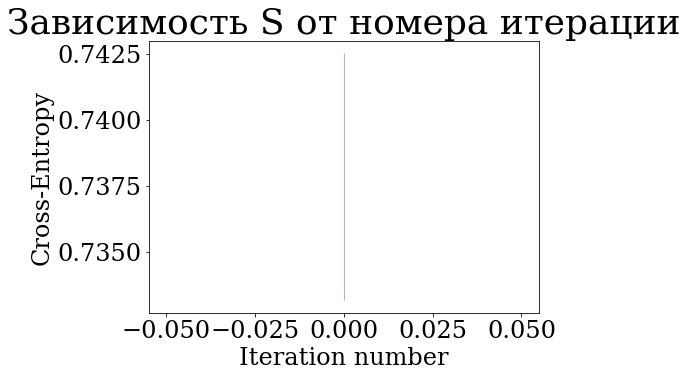

In [216]:
plt.plot(np.arange(len(mean_costs)),mean_costs)
plt.fill_between(np.arange(len(mean_costs)), mean_costs-error, mean_costs+error, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('Iteration number')
plt.ylabel('Cross-Entropy')
plt.title('Зависимость S от номера итерации')